In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 


import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
breath_df = pd.read_pickle('breath_pickle')

In [3]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [4]:
under2 = under2[0:100]

## Create Windowed Data

In [6]:
def split_trace(sequence, n_steps, n_output):
    X, y = list(), list()
    
    i = 0
    while i < len(sequence)-n_output:
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-n_output:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+n_output]
        X.append(seq_x)
        y.append(seq_y)
        
        i += n_output
        
    return np.array(X), np.array(y)
    

In [7]:
num_outputs = 100

In [8]:
traces = []
next_pt = []
trace_num = []
i = 0
for row in under2['Trace']:
    Xs, ys = split_trace(row, 100, num_outputs)
    traces.append(Xs)
    next_pt.append(ys)
    trace_num.append(np.ones(len(Xs), dtype='int64')*i)
    i += 1

In [9]:
traces2 = [np.array(x, dtype='float32') for sublist in traces for x in sublist]
next_pt2 = [x for sublist in next_pt for x in sublist]
trace_num2 = [i for row in trace_num for i in row]

In [10]:
breath_df2 = pd.DataFrame({"Trace":traces2, "Next_pts": next_pt2, "Trace_num":trace_num2})

## Train Test Split

In [12]:
df = breath_df2.copy()

In [13]:
df['Trace_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [14]:
train = df[df['Trace_num']>=51]
valid = df[(df['Trace_num']>=40) & (df['Trace_num']<51)]
test = df[df['Trace_num']<40]

In [15]:
X_train = train['Trace']
y_train = train['Next_pts']

X_val = valid['Trace']
y_val = valid['Next_pts']

X_test = test['Trace']
y_test = test['Next_pts']

## Scale Data

In [16]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [17]:
x_train, x_val = normalize(X_train, X_val)

In [18]:
x_train, x_test = normalize(X_train, X_test)

## Reshape

In [19]:
def reshape_series(series):
    series = np.transpose(series)
    return series.reshape(series.shape[0],series.shape[1], 1)

In [20]:
x_train = reshape_series(x_train)
x_val = reshape_series(x_val)
x_test = reshape_series(x_test)

In [21]:
y_train2 = reshape_series(list(y_train))
y_val2 = reshape_series(list(y_val))
y_test2 = reshape_series(list(y_test))

In [ ]:
# plot example of windowed data  
plt.figure(figsize = (10, 6)) 
plt.plot(np.arange(0, iw), xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], Ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

## Initialize Data for Model

In [22]:
#dataset
from torch.utils.data import Dataset

In [23]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [24]:
dataset = timeseries(x_train,y_train2)
test_dataset = timeseries(x_val,y_val2)

In [25]:
final_test_dataset = timeseries(x_test,y_test2)

In [26]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=200)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=200)

## Define LSTM Encoder and Decoder (Multistep Prediction)

In [27]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [28]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


## Define Model

In [29]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
        
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len,batch_size,learning_rate = 0.01):
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                batch_loss = 0.
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

        
    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## Best Model

In [31]:
mymodel = lstm_seq2seq(input_size=1, hidden_size=5)
print(f'Model Details - Hidden Size {5} \t Learning Rate: {0.001}')
train_loss = mymodel.train_model(dataset.x, dataset.y, n_epochs = 25, target_len = num_outputs, batch_size = 200, learning_rate = 0.001)
modname = 'lstm_encode_decode_' + '100'
torch.save(mymodel, modname)


Model Details - Hidden Size 5 	 Learning Rate: 0.001


100%|██████████| 25/25 [00:15<00:00,  1.65it/s, loss=0.607]


## Plots

In [32]:
mod = lstm_seq2seq(input_size=1, hidden_size=5)
mod = torch.load('lstm_encode_decode_100')

In [33]:
mod

lstm_seq2seq(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 5)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 5)
    (linear): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [34]:
def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, unscaled_xtrain, unscaled_xtest, num_rows = 4):

    # input window size
    iw = Xtrain.shape[0]
    ow = Ytest.shape[0]

    # figure setup 
    num_cols = 2
    num_plots = num_rows * num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize = (10, 13))

    # plot training/test predictionsabs
    for ii in range(num_rows):
        # train set
        xt = reshape_series(list(unscaled_xtrain))
        
        jj = np.random.randint(0, len(Xtrain))
        X_train_plt = Xtrain[:, jj, :]
        Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor), target_len = ow)

        ax[ii, 0].plot(np.arange(0, iw), xt[:, jj, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, jj, 0]], Ytrain[:, jj, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[xt[-1, jj, 0]], Y_train_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 0].set_xlim([0, iw + ow - 1])
        ax[ii, 0].set_xlabel('$t$')
        ax[ii, 0].set_ylabel('$y$')

        # test set
        xt = reshape_series(list(unscaled_xtest))
        X_test_plt = Xtest[:, jj, :]
        Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
        
        ax[ii, 1].plot(np.arange(0, iw), xt[:, jj, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, jj, 0]], Ytest[:, jj, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, jj, 0]], Y_test_pred[:, 0]]),
                      color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 1].set_xlim([0, iw + ow - 1])
        ax[ii, 1].set_xlabel('$t$')
        ax[ii, 1].set_ylabel('$y$')
        
        # Labels
        if ii == 0:
            ax[ii, 0].set_title('Train')

            ax[ii, 1].legend(bbox_to_anchor=(1, 1))
            ax[ii, 1].set_title('Test')

        plt.suptitle('LSTM Encoder-Decoder Prediction Examples', x = 0.445, y = 1.)
        plt.tight_layout()
        plt.subplots_adjust(top = 0.95)
        
        plt.savefig('prediction_examples4.png')


    return 

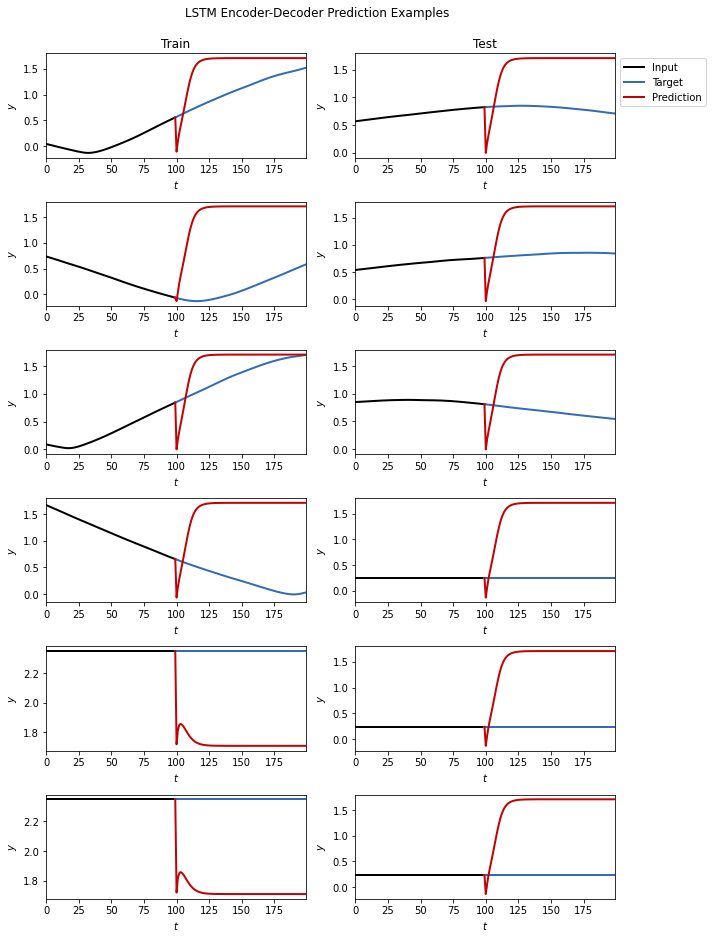

In [35]:
plot_train_test_results(mod, x_train, y_train2, x_val, y_val2, X_train, X_val, 6)

## Plots

In [36]:
final_test_dataset.x.shape

torch.Size([100, 2312, 1])

In [37]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

In [47]:
def gather_preds(mymodel, dataset):
    preds = []
    for i in range(dataset.x.shape[1]):
        x_t = dataset.x[:, i, :]
        Y_pred = mymodel.predict(x_t, target_len = num_outputs)
        preds.append(Y_pred)
    return preds

In [48]:
test_preds = gather_preds(mod, final_test_dataset)
valid_preds = gather_preds(mod, test_dataset)
train_preds = gather_preds(mod, dataset)

In [49]:
train['preds'] = train_preds
valid['preds'] = valid_preds
test['preds'] = test_preds

<ipython-input-49-9221ef3f2022>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['preds'] = train_preds
<ipython-input-49-9221ef3f2022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['preds'] = valid_preds
<ipython-input-49-9221ef3f2022>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [50]:
train

,Trace,Next_pts,Trace_num,preds
3120,"[0.0002, 0.0006, 0.001, 0.0017, 0.0025, 0.0037...","[0.7513, 0.7615, 0.7716, 0.7817, 0.7917, 0.801...",51,"[[-0.051177323], [0.13907558], [0.28313074], [..."
3121,"[0.7513, 0.7615, 0.7716, 0.7817, 0.7917, 0.801...","[1.6083, 1.6162, 1.624, 1.6319, 1.6399, 1.6478...",51,"[[1.6059963], [1.7542601], [1.7960901], [1.800..."
3122,"[1.6083, 1.6162, 1.624, 1.6319, 1.6399, 1.6478...","[1.9011, 1.8924, 1.8835, 1.8743, 1.8647, 1.854...",51,"[[1.6653322], [1.7934153], [1.833477], [1.8399..."
3123,"[1.9011, 1.8924, 1.8835, 1.8743, 1.8647, 1.854...","[0.9206, 0.9113, 0.9018, 0.8923, 0.8827, 0.873...",51,"[[0.11714194], [0.24704194], [0.36744127], [0...."
3124,"[0.9206, 0.9113, 0.9018, 0.8923, 0.8827, 0.873...","[0.0999, 0.0954, 0.0912, 0.0873, 0.0837, 0.080...",51,"[[-0.13234338], [0.05015611], [0.21559837], [0..."
...,...,...,...,...
6295,"[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...","[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...",99,"[[-0.1322017], [0.058526576], [0.22176817], [0..."
6296,"[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...","[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...",99,"[[-0.1322017], [0.058526576], [0.22176817], [0..."
6297,"[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...","[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...",99,"[[-0.1322017], [0.058526576], [0.22176817], [0..."
6298,"[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...","[0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.256...",99,"[[-0.1322017], [0.058526576], [0.22176817], [0..."


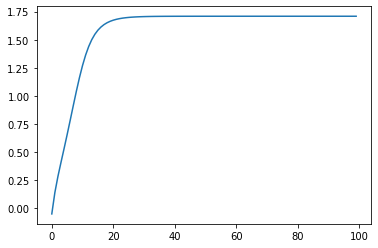

In [81]:
plt.plot(train['preds'][3120])

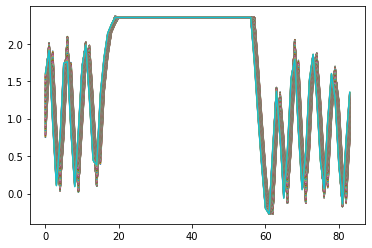

In [96]:
plt.plot(train_full_traces[51])
plt.show()

In [92]:
train_full_traces.index

Int64Index([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64', name='Trace_num')

In [57]:
train.to_pickle("train_df_100.pkl")  
valid.to_pickle("valid_df_100.pkl")  
test.to_pickle("test_df_100.pkl")  

In [58]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

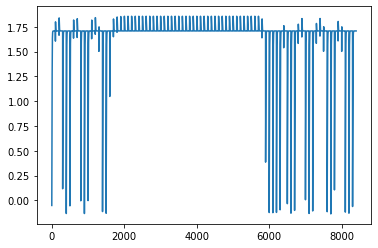

In [59]:
train_pred_trace = train.groupby('Trace_num')['preds'].apply(list)
valid_pred_trace = valid.groupby('Trace_num')['preds'].apply(list)
test_pred_trace = test.groupby('Trace_num')['preds'].apply(list)

In [83]:
train_pred_trace

Trace_num
51    [[[-0.051177323], [0.13907558], [0.28313074], ...
52    [[[-0.05781257], [0.13409096], [0.27927247], [...
53    [[[-0.018742755], [0.1630141], [0.3023159], [0...
54    [[[-0.0003913194], [0.17605615], [0.31285077],...
55    [[[-0.00879854], [0.1700118], [0.3078729], [0....
56    [[[-0.034787655], [0.1512604], [0.29279974], [...
57    [[[-0.09845203], [0.100442834], [0.25322092], ...
58    [[[-0.04302323], [0.14521123], [0.28800488], [...
59    [[[-0.13134235], [0.06193374], [0.22431867], [...
60    [[[-0.12807229], [0.067295395], [0.22827484], ...
61    [[[-0.12002838], [0.07827855], [0.2364695], [0...
62    [[[-0.115735084], [0.08314561], [0.2401025], [...
63    [[[-0.11011198], [0.08906755], [0.24453914], [...
64    [[[-0.13394186], [0.056653716], [0.22043343], ...
65    [[[-0.1224854], [0.075217925], [0.23417732], [...
66    [[[-0.078923374], [0.11718671], [0.2659521], [...
67    [[[-0.09910452], [0.09973035], [0.25261253], [...
68    [[[-0.106875494], [0.09234413], 

ValueError: x and y can be no greater than 2D, but have shapes (53,) and (53, 100, 1)

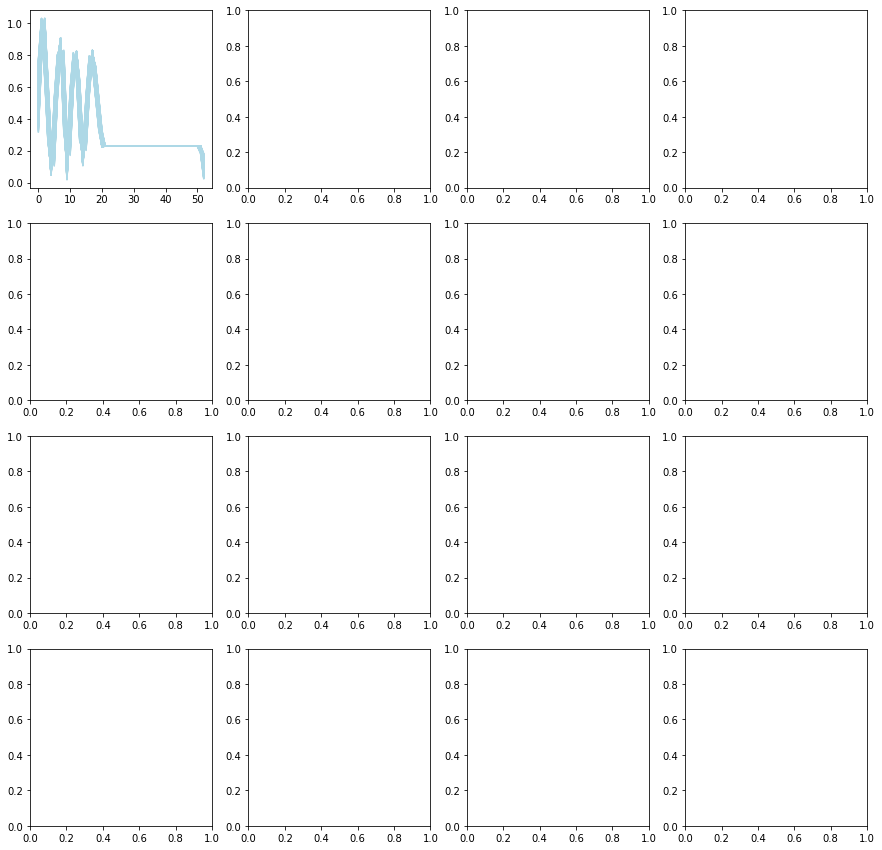

In [99]:
fig, axs = plt.subplots(4,4,figsize=(15,15))
for i in range(4):
    for j in range(4):
        idx = np.random.choice(test_full_traces.index)
        axs[i,j].plot(test_full_traces[idx], 'lightblue')
        axs[i,j].plot(test_pred_trace[idx], 'hotpink',linestyle='--')
plt.show()

In [67]:
idx = np.random.choice(test_full_traces.index)
print(idx)
axs[i,j].plot(test_pred_trace[idx][0], 'hotpink',linestyle='--')

34


ValueError: x and y can be no greater than 2D, but have shapes (65,) and (65, 100, 1)

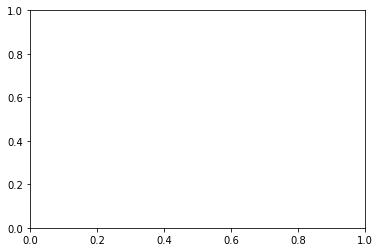

In [74]:
plt.plot(test_pred_trace[12])